In [37]:
#https://www.kaggle.com/datasets/rakannimer/air-passengers

In [38]:
from datetime import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pyplot import rcParams

In [39]:
path = "/content/AirPassengers.csv"
dataset = pd.read_csv(path)
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format=True)
indexedDataset = dataset.set_index(['Month'])
indexedDataset.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


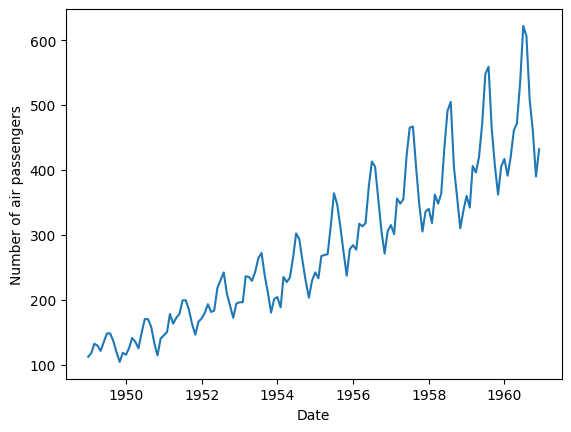

In [40]:
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(indexedDataset)

In [41]:
rolmean = indexedDataset.rolling(window=12).mean()
rolstd = indexedDataset.rolling(window=12).std()
print(rolmean, rolstd)

            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01   463.333333
1960-09-01   467.083333
1960-10-01   471.583333
1960-11-01   473.916667
1960-12-01   476.166667

[144 rows x 1 columns]             #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01    83.630500
1960-09-01    84.617276
1960-10-01    82.541954
1960-11-01    79.502382
1960-12-01    77.737125

[144 rows x 1 columns]


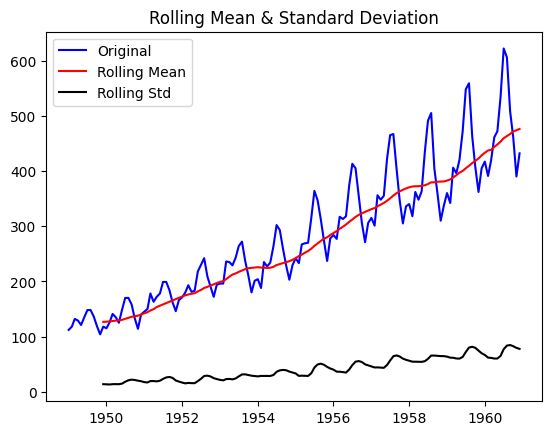

In [42]:
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

**Perform Augumented Dickey-Fuller Test**

In [43]:
print("Results of Dickey Fuller Test:")
dftest = adfuller(indexedDataset['#Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
  dfoutput['Critical Value(%s)'%key] = value
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value(1%)              -3.481682
Critical Value(5%)              -2.884042
Critical Value(10%)             -2.578770
dtype: float64


**Estimating Trend**

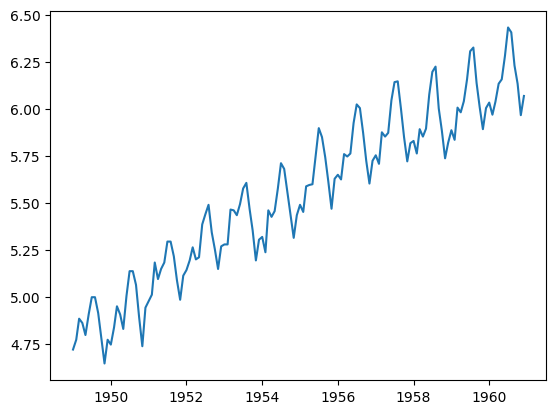

In [44]:
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

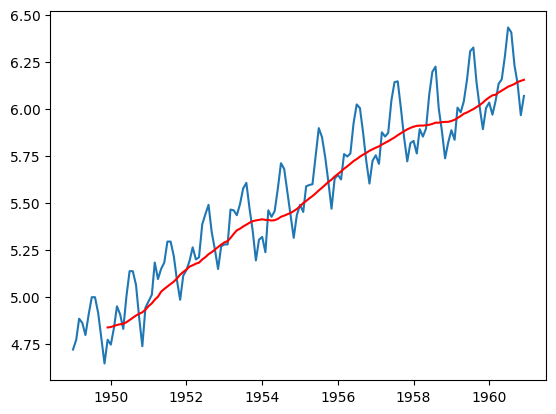

In [45]:
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [46]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


In [47]:
#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


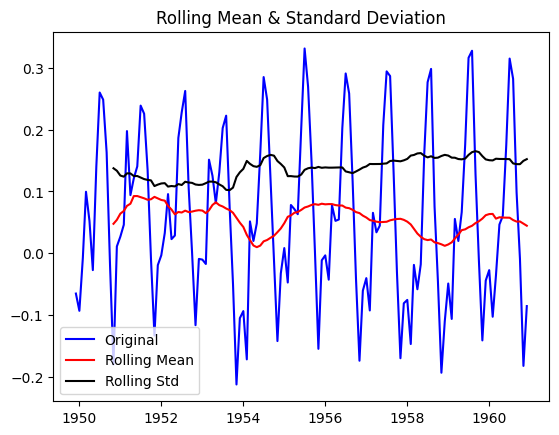


Results of Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [48]:
def test_stationarity(timeseries):

    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    print()
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(datasetLogScaleMinusMovingAverage)

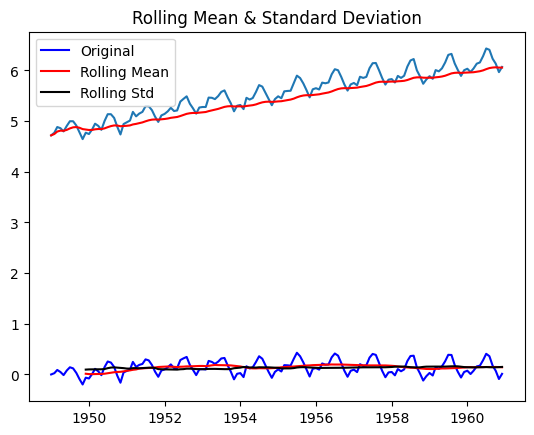


Results of Dickey Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [49]:
#Exponential Decay Transformation
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

**Time Shift Transformation**

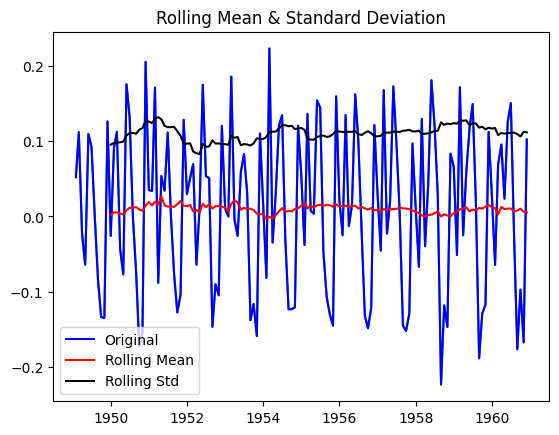


Results of Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [50]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

In [51]:
decomposition = seasonal_decompose(indexedDataset_logScale)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

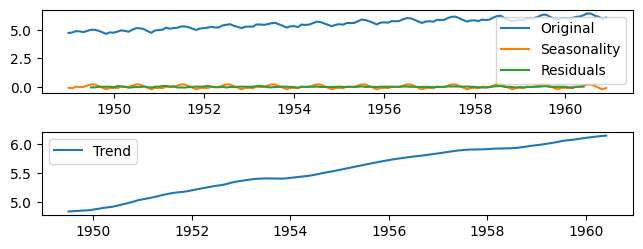

In [52]:
plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

**Plotting ACF & PACF**

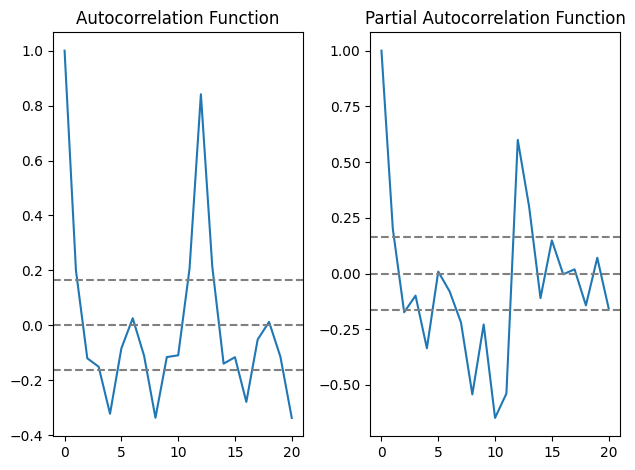

In [53]:
lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Plotting AR model


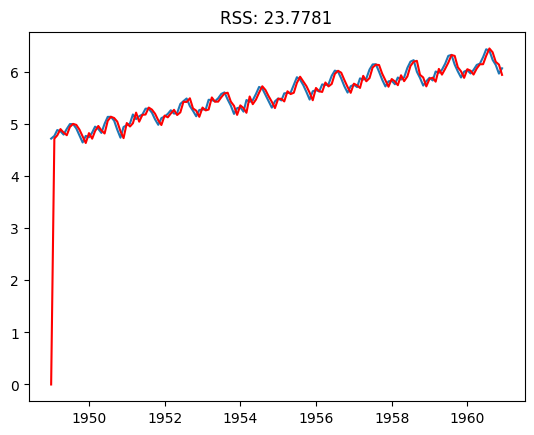

In [54]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(indexedDataset_logScale, order=(2, 1, 0))
results_AR = model.fit()
plt.plot(indexedDataset_logScale)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_AR.fittedvalues - indexedDataset_logScale.squeeze())**2))
print('Plotting AR model')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Plotting MA model
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 128.890
Date:                Wed, 22 Nov 2023   AIC                           -247.780
Time:                        16:29:32   BIC                           -232.965
Sample:                    01-01-1949   HQIC                          -241.760
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2432      0.166      1.469      0.142      -0.081       0.568
ar.L2          0.2677      0.199      1.344      0.179      -0.123       0.658
ma.L1         -0.0867      0.118  

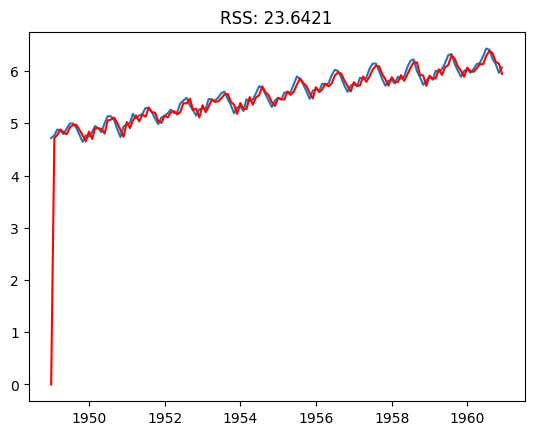

In [55]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(indexedDataset_logScale, order=(2, 1, 2))
results_MA = model.fit()
plt.plot(indexedDataset_logScale)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_MA.fittedvalues - indexedDataset_logScale.squeeze())**2))
print('Plotting MA model')

print(results_MA.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Plotting ARIMA model


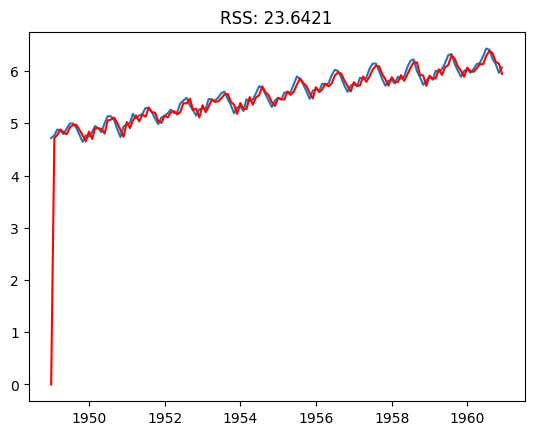

In [56]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(indexedDataset_logScale, order=(2, 1, 2))
results_ARIMA = model.fit()
plt.plot(indexedDataset_logScale)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_ARIMA.fittedvalues - indexedDataset_logScale.squeeze())**2))
print('Plotting ARIMA model')

In [57]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-01-01    0.000000
1949-02-01    4.718499
1949-03-01    4.776385
1949-04-01    4.883216
1949-05-01    4.824421
dtype: float64


**Convert to cumulative sum**

In [58]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

Month
1949-01-01      0.000000
1949-02-01      4.718499
1949-03-01      9.494884
1949-04-01     14.378100
1949-05-01     19.202522
                 ...    
1960-08-01    765.821335
1960-09-01    772.162775
1960-10-01    778.339964
1960-11-01    784.481928
1960-12-01    790.426499
Length: 144, dtype: float64


In [59]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['#Passengers'].iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01     4.718499
1949-02-01     9.436998
1949-03-01    14.213383
1949-04-01    19.096599
1949-05-01    23.921020
dtype: float64

In [60]:
predictions_ARIMA

Month
1949-01-01    1.120000e+02
1949-02-01    1.254400e+04
1949-03-01    1.488654e+06
1949-04-01    1.965838e+08
1949-05-01    2.447751e+10
                  ...     
1960-08-01             inf
1960-09-01             inf
1960-10-01             inf
1960-11-01             inf
1960-12-01             inf
Length: 144, dtype: float64